In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial.distance
import seaborn as sns
import sqlalchemy

from dtaidistance import clustering
from dtaidistance import dtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot
from sampling import plot_trend_samples

In [2]:
plt.style.use('ggplot')
sns.set_style('white')

In [3]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [4]:
num_weeks = 6
sell_data = load_transform_combine(num_weeks, connection)
xticks = sell_data['weekday_observed'].unique()

distances = np.load('data/distances.npy')

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:00<00:00, 12264.05it/s]


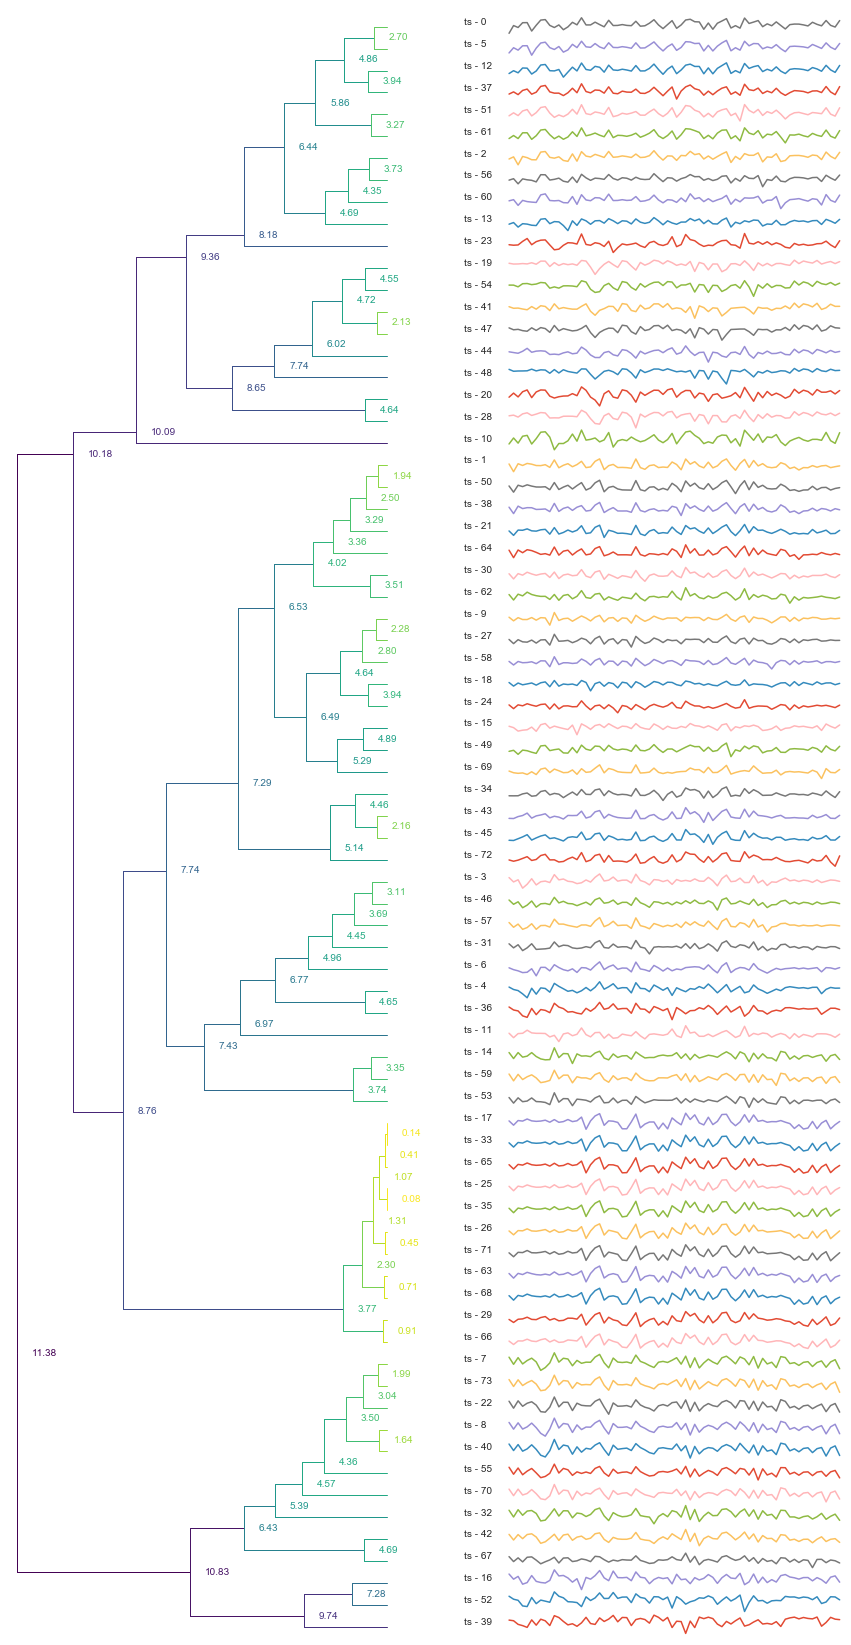

In [5]:
# clustering from dtaidistance documentation
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
model2 = clustering.HierarchicalTree(model1, show_ts_label=True)
cluster_idx = model2.fit(distances)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
show_ts_label = lambda idx: "ts - " + str(idx)
model2.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.show()

In [6]:
# condensed distance matrix https://stackoverflow.com/questions/18952587/
condensed_distances = scipy.spatial.distance.squareform(distances)

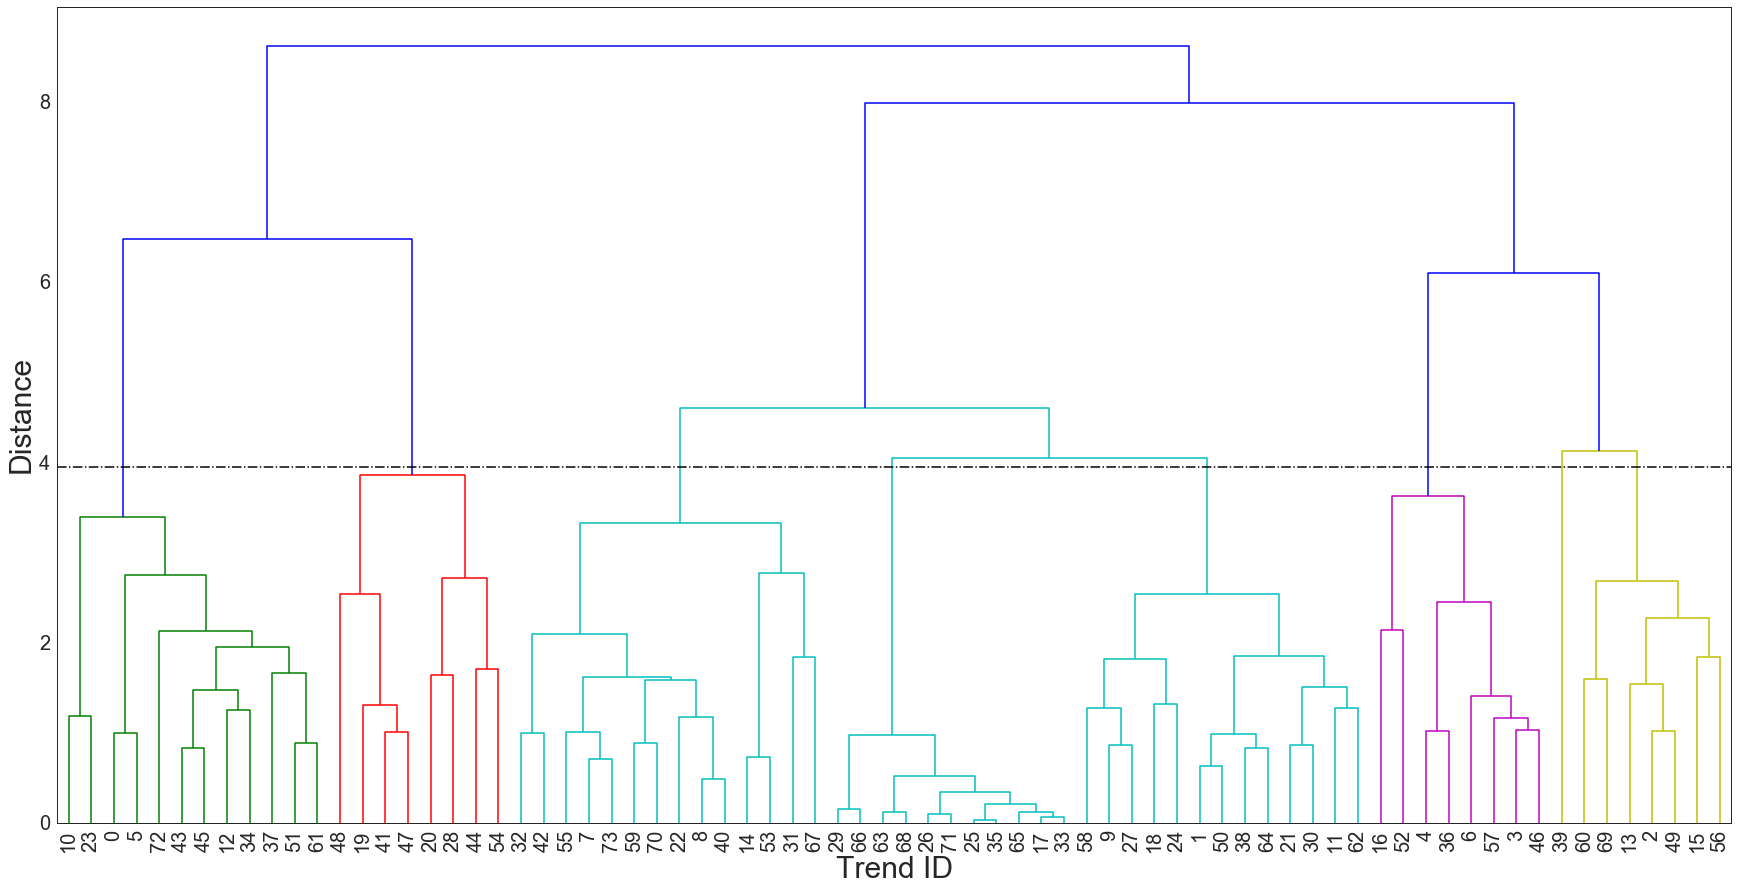

In [7]:
Z = linkage(condensed_distances, method='complete', metric='euclidean')

fig = plt.figure(figsize=(30, 15))
dn = dendrogram(Z, leaf_font_size=20)
plt.axhline(color='black', linestyle='-.', y=3.95) 
plt.xlabel('Trend ID', fontsize=30)
plt.ylabel('Distance', fontsize=30)
plt.yticks(size=20)
plt.show()

In [8]:
num_clusters = 8
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

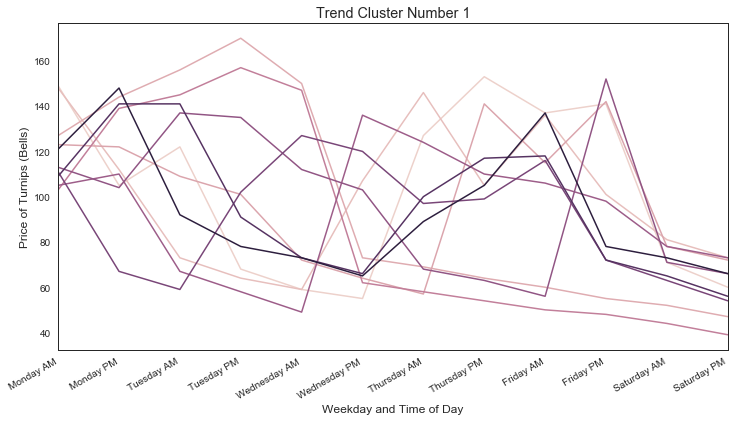

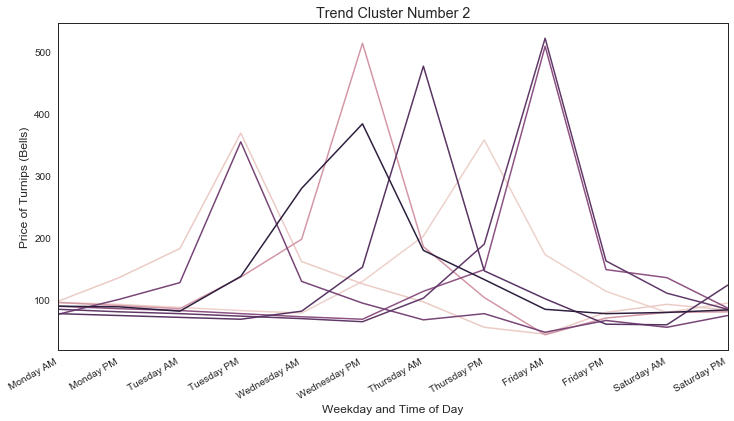

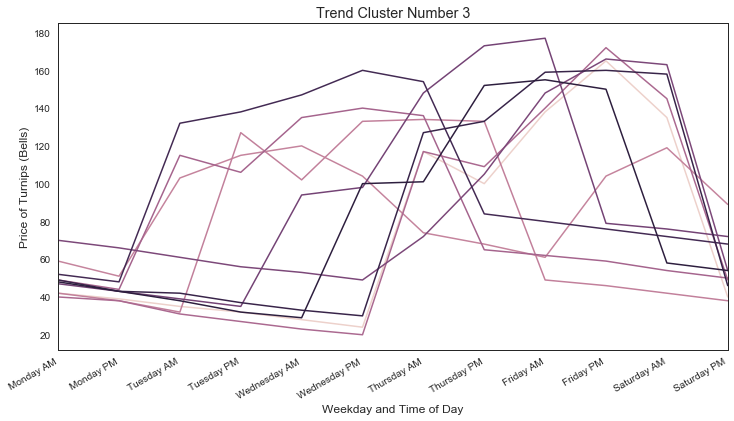

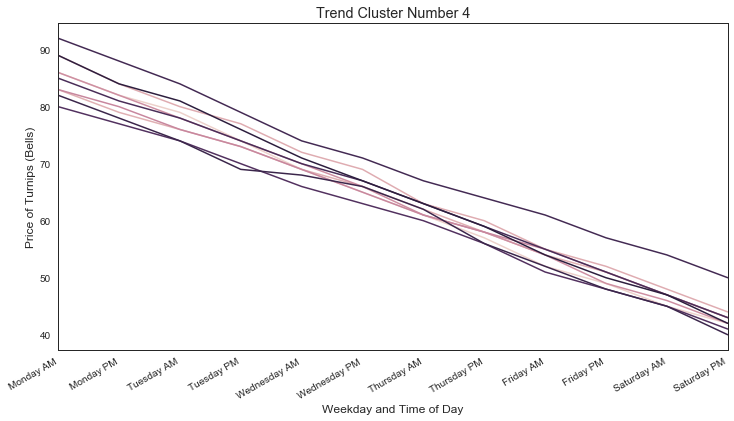

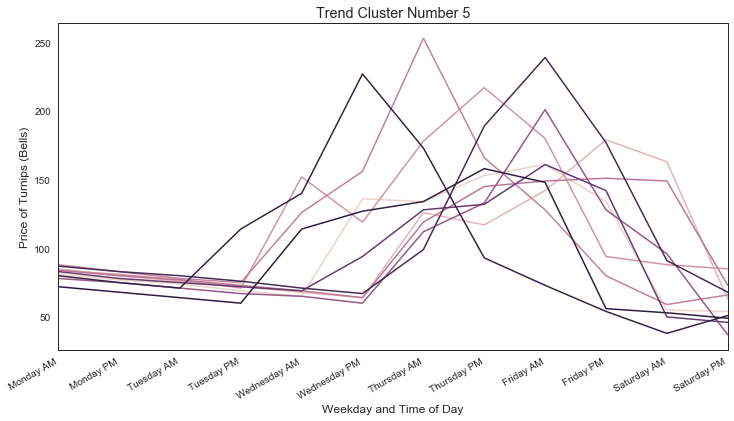

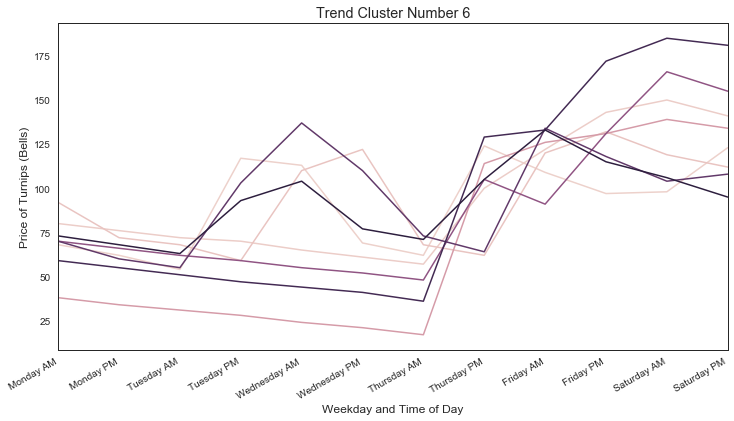

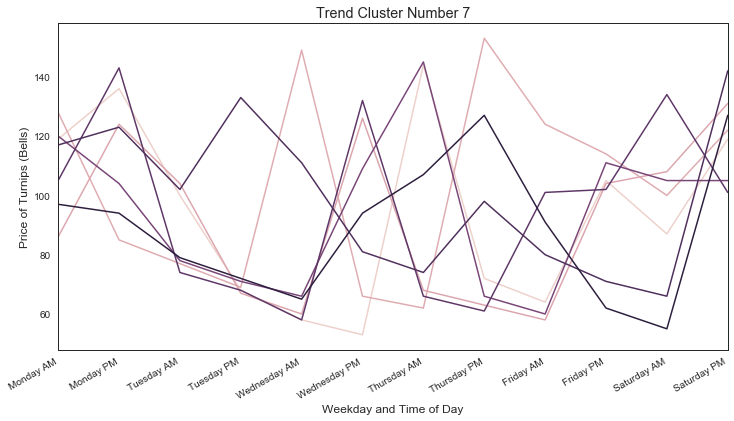

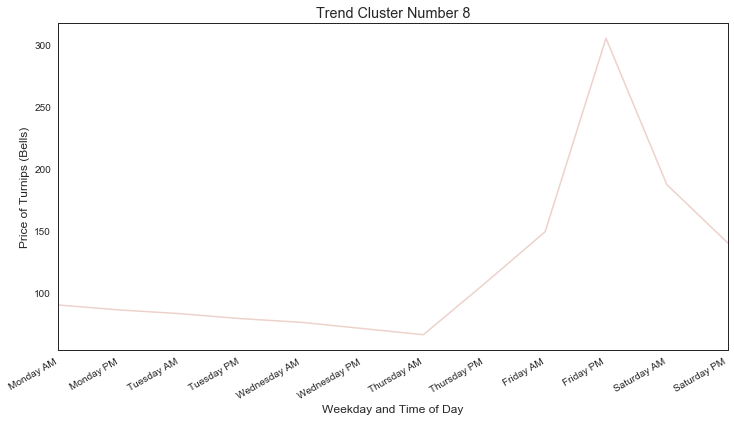

In [9]:
plot_trend_samples(sell_data, labels, num_clusters)

In [10]:
predictions = pd.read_csv('data/predictions.csv')
predictions['hierarchical'] = labels
predictions.to_csv('data/predictions.csv', index=False)